In [2]:
from typing import Any, Callable

import jax
from jax import grad
import jax.numpy as jnp
from jaxtyping import Array, Float, UInt, jaxtyped
from beartype import beartype as typechecker
from tqdm import tqdm
from sklearn.datasets import make_blobs
import matplotlib.pyplot as plt

In [3]:
def typed(f: Callable[..., Any]) -> Callable[..., Any]:
    return jaxtyped(typechecker=typechecker)(f)

In [4]:
import lovely_jax as lj

lj.monkey_patch()

In [5]:
seed = jax.random.PRNGKey(0)
x = jax.random.normal(seed, (2, 2))

In [6]:
jax.random.normal(seed, (2, 2))

Array[2, 2] n=4 x∈[-0.755, 1.816] μ=0.217 σ=1.010 cpu:0 [[1.816, -0.755], [0.340, -0.535]]

In [7]:
@typed
@jax.jit
def isotropic_gaussian(
    mu: Float[Array, "N D"], sigma: float = 1.0
) -> Float[Array, "N D"]:
    return 1 / (2 * jnp.pi * sigma**2) * jnp.exp(-((mu) ** 2) / (2 * sigma**2))

In [8]:
isotropic_gaussian(jnp.array([[0.0, 1.0, 2.0], [3.0, 1.0, 2.0]]))

Array[2, 3] n=6 x∈[0.002, 0.159] μ=0.066 σ=0.056 cpu:0 [[0.159, 0.097, 0.022], [0.002, 0.097, 0.022]]

In [9]:
@typed
def sigmoid(x: Float[Array, "B ... I"]) -> Float[Array, "B ... I"]:
    return 1 / (1 + jnp.exp(-x))


@typed
def linear(
    x: Float[Array, "B ... I"], params: dict[str, Float[Array, "..."]]
) -> Float[Array, "B ... O"]:
    return jnp.dot(x, params["weight"].T) + params["bias"]


@typed
def init_linear(
    in_features: int, out_features: int, key: UInt[Array, "2"]
) -> dict[str, Float[Array, "..."]]:
    weight = jax.random.normal(key, (out_features, in_features))
    bias = jax.random.normal(key, (out_features,))
    return {"weight": weight, "bias": bias}


@typed
def logreg(
    x: Float[Array, "B ... 2"], params: dict[str, Float[Array, "..."]]
) -> Float[Array, "B ... 1"]:
    return sigmoid(linear(x, params))


@typed
def init_model(key: UInt[Array, "2"]) -> dict[str, Float[Array, "..."]]:
    return init_linear(2, 1, key)

In [10]:
x_blobs, y_blobs = make_blobs(
    n_samples=1000,
    centers=2,
    n_features=2,
    cluster_std=0.75,
    random_state=seed[0].item(),
)
x = jnp.array(x_blobs, dtype=jnp.float32)
y = jnp.array(y_blobs, dtype=jnp.float32).reshape(-1, 1)

yh = logreg(x, init_model(seed))

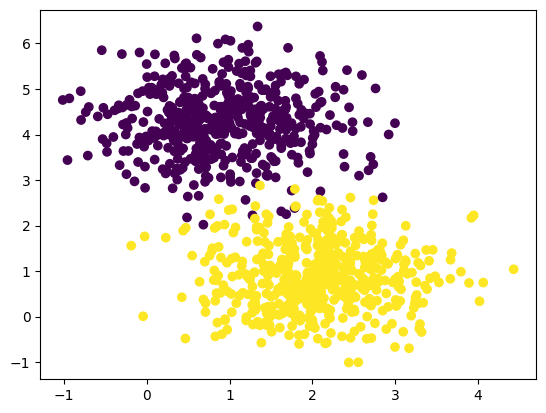

In [11]:
plt.scatter(x[:, 0], x[:, 1], c=y)
plt.show()

In [12]:
@typed
def accuracy_fn(
    y_true: Float[Array, "B 1"], y_pred: Float[Array, "B 1"]
) -> Float[Array, "B 1"]:
    return (y_true == y_pred).astype(jnp.float32)


@typed
def train_step(
    x: Float[Array, "B ... 2"],
    y: Float[Array, "B 1"],
    params: dict[str, Float[Array, "..."]],
) -> tuple[dict[str, Float[Array, "..."]], Float[Array, ""], Float[Array, ""]]:
    def loss_fn(params: dict[str, Float[Array, "..."]]) -> Float[Array, ""]:
        yh = logreg(x, params)
        return -jnp.mean(y * jnp.log(yh) + (1 - y) * jnp.log(1 - yh))

    loss = loss_fn(params)
    yh = logreg(x, params)
    accuracy = jnp.mean((y == (yh > 0.5)).astype(jnp.float32))

    grads = grad(loss_fn)(params)
    params = jax.tree.map(lambda p, g: p - 0.01 * g, params, grads)
    return params, loss, accuracy


@typed
def train(
    x: Float[Array, "B ... 2"],
    y: Float[Array, "B 1"],
    params: dict[str, Float[Array, "..."]],
    epochs: int = 100,
) -> tuple[dict[str, Float[Array, "..."]], list[float], list[float]]:
    losses = []
    accuracies = []
    pbar = tqdm(range(epochs))
    for i in pbar:
        params, loss, accuracy = train_step(x, y, params)
        losses.append(float(loss))
        accuracies.append(float(accuracy))
        pbar.set_description(
            f"Loss: {float(loss):.4f}, Accuracy: {float(accuracy):.4f}"
        )
    return params, losses, accuracies

In [13]:
initial_params = init_model(seed)
params, losses, accuracies = train(x, y, initial_params, epochs=1000)

Loss: 0.1423, Accuracy: 0.9660: 100%|██████████| 1000/1000 [00:07<00:00, 136.08it/s]
